### Optimal control of deterministic phenomenological models
This notebook shows how to compute the optimal control (OC) signal for phenomenological models (FHN, Hopf) for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_fhn
from neurolib.control.optimal_control import oc_hopf
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = FHNModel()
# model = HopfModel()    # OC can be computed for the Hopf model completely analogously

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.
model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

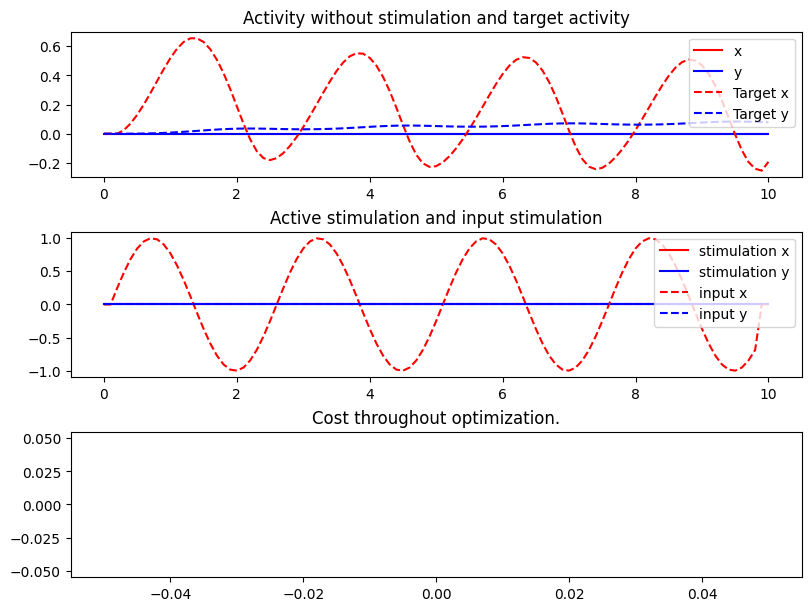

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["x_ext"] = input
model.params["y_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 0.5533851530971279
Cost in iteration 25: 0.24242291461839643
Cost in iteration 50: 0.158446723522036
Cost in iteration 75: 0.12000029040838785
Cost in iteration 100: 0.09606458437628632
Cost in iteration 125: 0.07875899052824147
Cost in iteration 150: 0.06567349888722092
Cost in iteration 175: 0.05561717121960812
Cost in iteration 200: 0.046820879161951934
Cost in iteration 225: 0.03978086855629592
Cost in iteration 250: 0.03392391540076887
Cost in iteration 275: 0.028992099916335265
Cost in iteration 300: 0.02479079077699601
Cost in iteration 325: 0.02133038041643569
Cost in iteration 350: 0.01827940217433275
Cost in iteration 375: 0.01576269909191435
Cost in iteration 400: 0.01356584870792306
Cost in iteration 425: 0.011714500580338103
Cost in iteration 450: 0.009981011218383684
Cost in iteration 475: 0.00859760015510665
Cost in iteration 500: 0.00738075695868313
Final cost : 0.00738075695868313


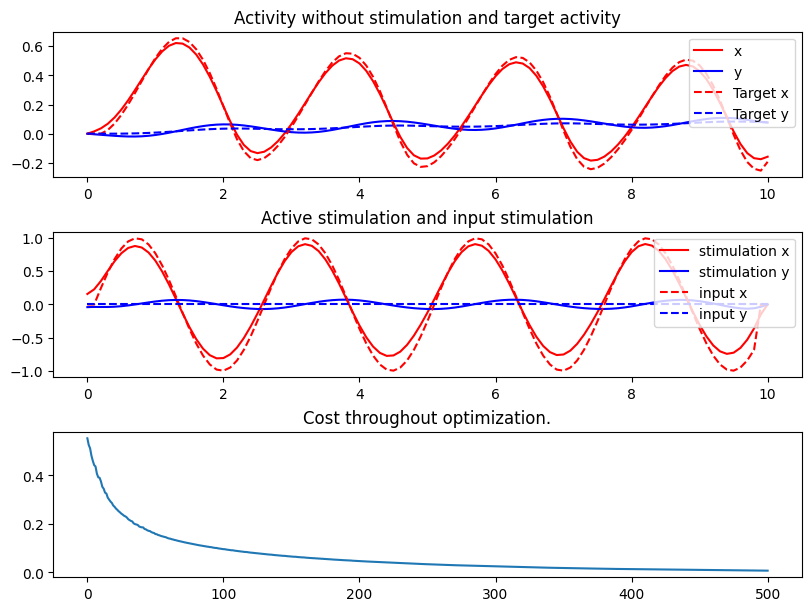

In [4]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=np.arange(0,501,25))
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, print_array=np.arange(0,501,25))

# per default, the weights are set to w_p = 1 and w_2 = 0, meaning that energy costs do not contribute. The algorithm will produce a control such that the signal will match the target exactly, regardless of the strength of the required control input.
# If you want to adjust the ratio of precision and energy weight, you can change the values in the weights dictionary
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00738075695868313
Cost in iteration 25: 0.006315387451922033
Cost in iteration 50: 0.0054110330147396765
Cost in iteration 75: 0.004519862815977452
Cost in iteration 100: 0.003828425847813059
Final cost : 0.003828425847813059


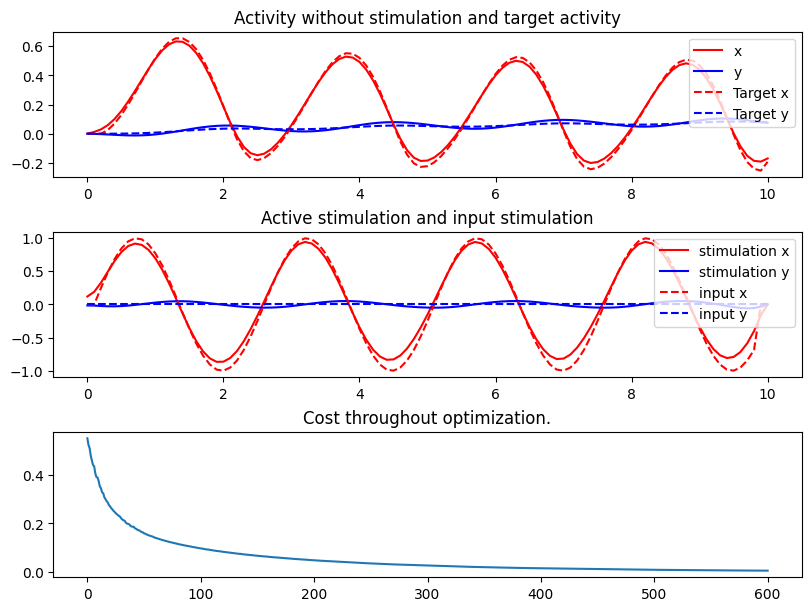

In [5]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network of neural populations (no delay)

Let us know study a simple 2-node network of FHN oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

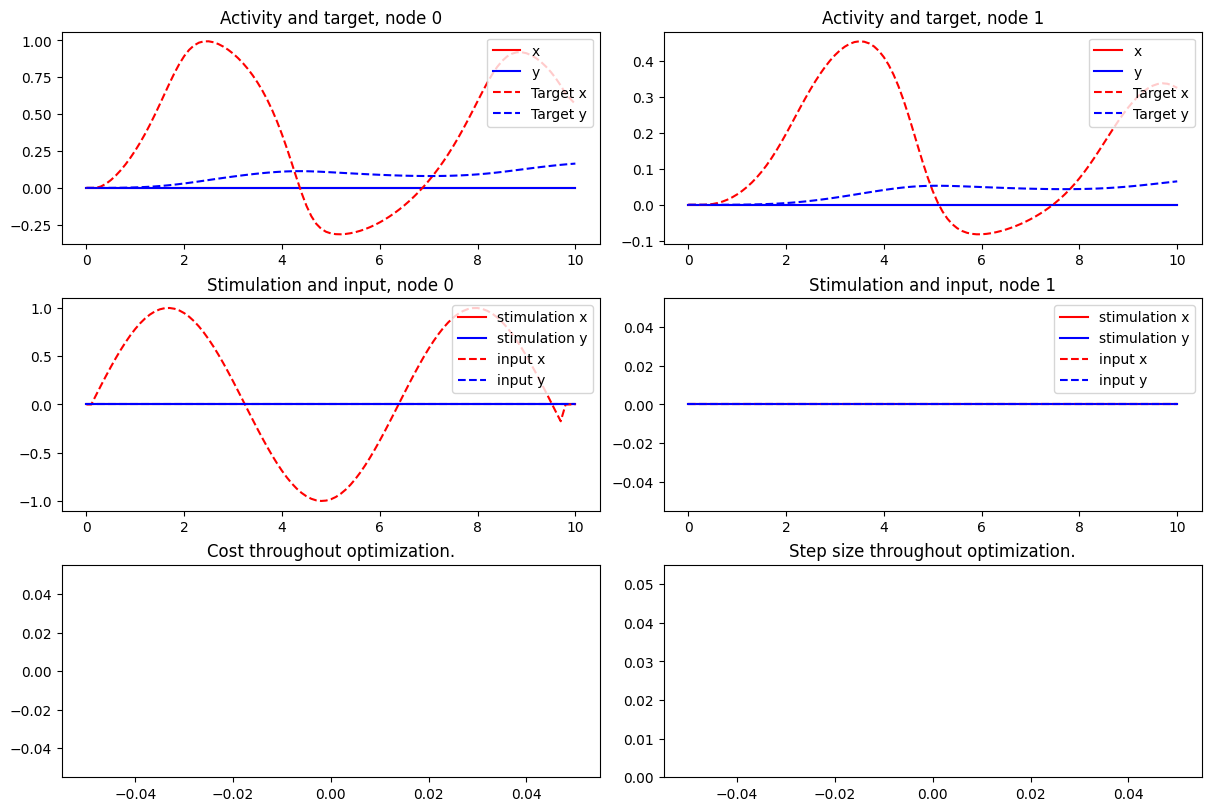

In [6]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["xs_init"] = np.vstack( [x_init, x_init] )
model.params["ys_init"] = np.vstack( [y_init, y_init] )

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.26634675059119883
Cost in iteration 25: 0.007720097126561813
Cost in iteration 50: 0.003468094766181124
Cost in iteration 75: 0.0019407060206990709
Cost in iteration 100: 0.0014869014234351547
Cost in iteration 125: 0.0012416880831819558
Cost in iteration 150: 0.0010926715307087121
Cost in iteration 175: 0.0009785714578839065
Cost in iteration 200: 0.000869098360775746
Cost in iteration 225: 0.0007820993626886074
Cost in iteration 250: 0.0007014496869583305
Cost in iteration 275: 0.0006336452348537247
Cost in iteration 300: 0.0005674277634957598
Cost in iteration 325: 0.0005103364437866029
Cost in iteration 350: 0.0004672824975698743
Cost in iteration 375: 0.0004270480894871657
Cost in iteration 400: 0.00038299359917409915
Cost in iteration 425: 0.0003386345074314633
Cost in iteration 450: 0.000282209674548586
Cost in iteration 475: 0.00025498430139313385
Cost in iteration 500: 0.00023170877040432997
Final cost : 0.00023

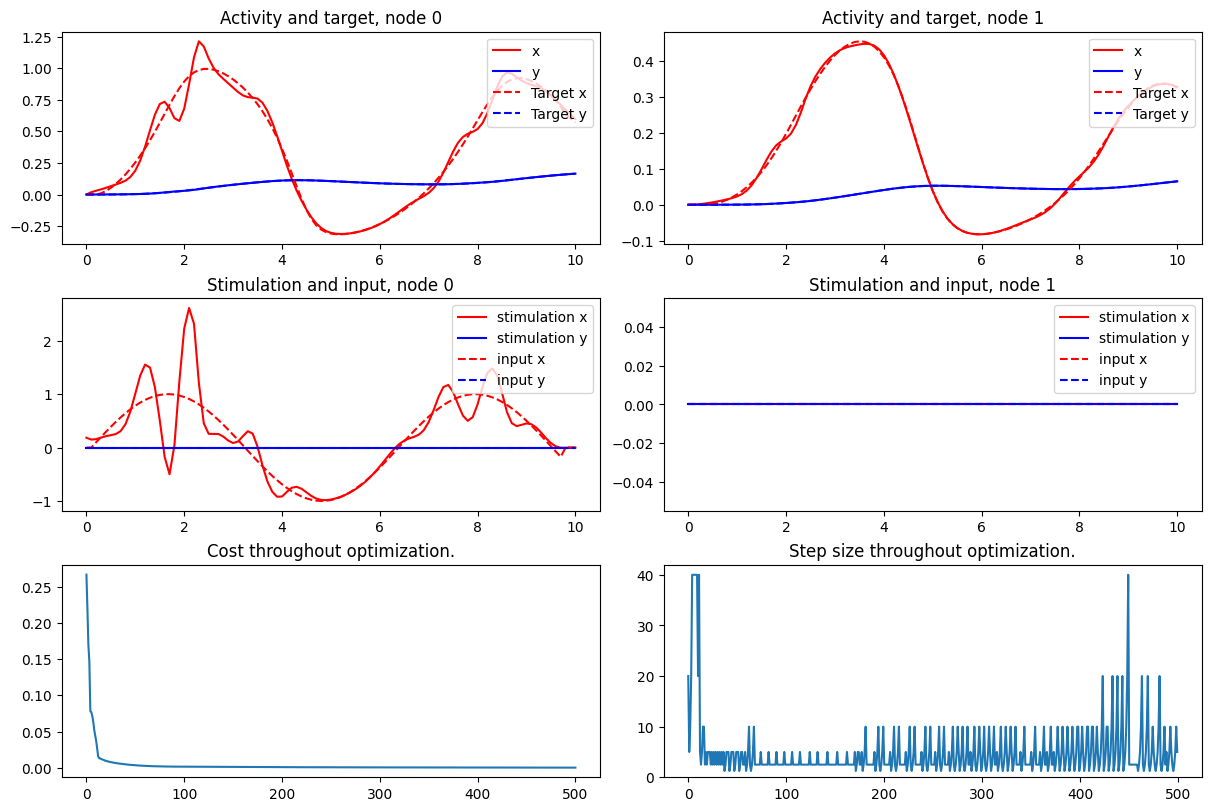

In [8]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00023170877040432997
Cost in iteration 25: 0.00021249031308175645
Cost in iteration 50: 0.00019830797442003183
Cost in iteration 75: 0.0001844977342869945
Cost in iteration 100: 0.00017230020232405932
Final cost : 0.00017230020232405932


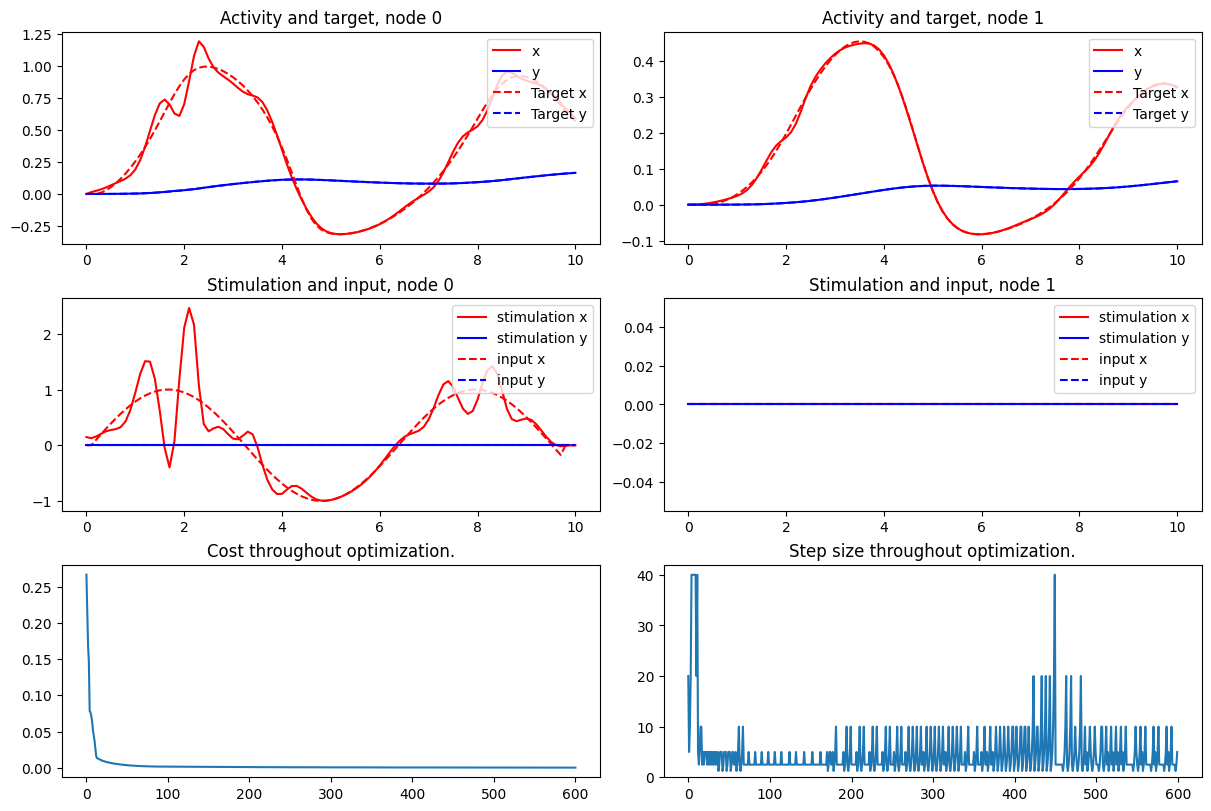

In [9]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

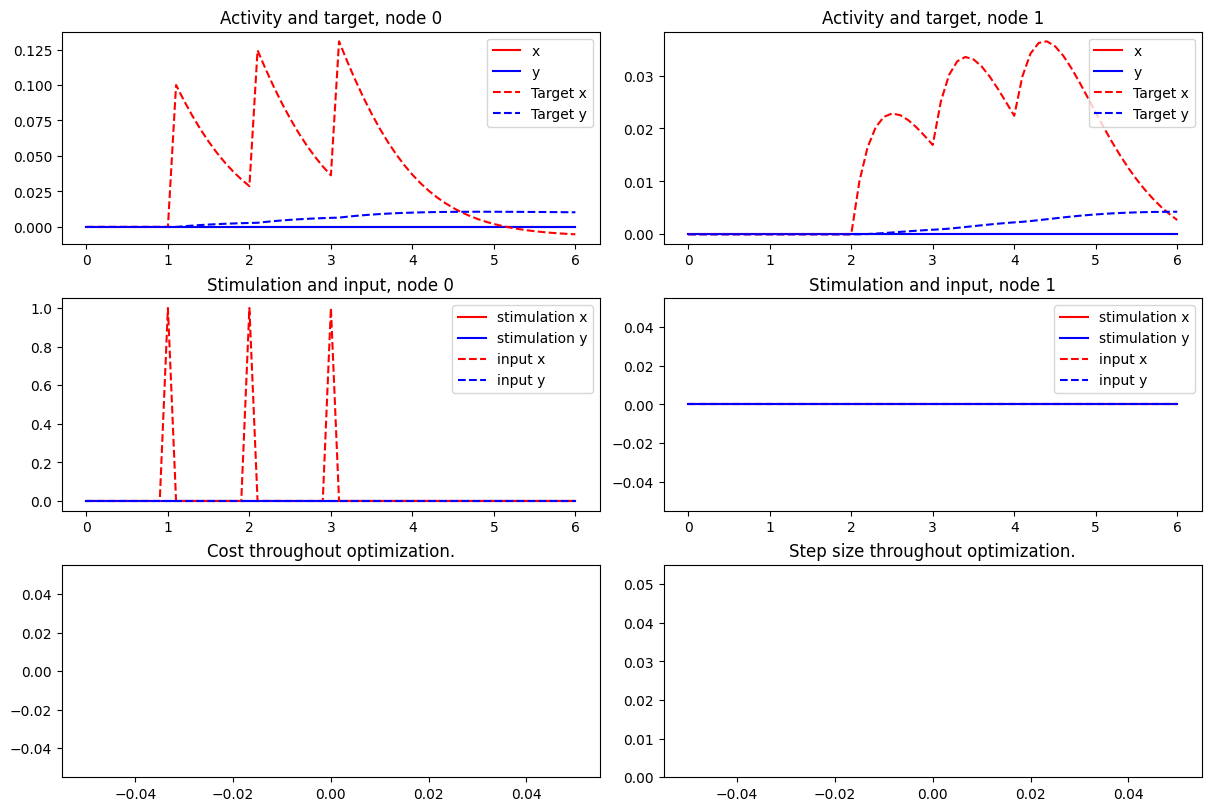

In [10]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt

# change coupling parameters for faster and stronger connection between nodes
model.params.K_gl = 1.

model.params.x_ext = np.zeros((1,))
model.params.y_ext = np.zeros((1,))

model.run()

e0 = model.x[0,-1]
e1 = model.x[1,-1]
i0 = model.y[0,-1]
i1 = model.y[1,-1]

maxdelay = model.getMaxDelay()

model.params["xs_init"] = np.array([[e0] * (maxdelay + 1), [e1] * (maxdelay + 1) ])
model.params["ys_init"] = np.array([[i0] * (maxdelay + 1), [i1] * (maxdelay + 1) ])

duration = 6.
model.params.duration = duration
time = np.arange(dt, duration+dt, dt)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.params["xs_init"] = np.array([[e0] * (maxdelay + 1), [e1] * (maxdelay + 1) ])
model.params["ys_init"] = np.array([[i0] * (maxdelay + 1), [i1] * (maxdelay + 1) ])
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.0011947065709511494
Cost in iteration 25: 1.89957139654923e-05
Cost in iteration 50: 1.2661264833225041e-05
Cost in iteration 75: 9.010644155785705e-06
Cost in iteration 100: 6.820944851923898e-06
Cost in iteration 125: 5.474911745391522e-06
Cost in iteration 150: 4.530608100186927e-06
Cost in iteration 175: 3.927022075378676e-06
Cost in iteration 200: 3.5063019127981866e-06
Cost in iteration 225: 3.1905412820140246e-06
Cost in iteration 250: 2.9567061175703823e-06
Cost in iteration 275: 2.7741407209279603e-06
Cost in iteration 300: 2.625794937490637e-06
Cost in iteration 325: 2.502192369572666e-06
Cost in iteration 350: 2.3959920314309225e-06
Cost in iteration 375: 2.303282831253026e-06
Cost in iteration 400: 2.2204517767977464e-06
Cost in iteration 425: 2.1458248650643035e-06
Cost in iteration 450: 2.0775097671229773e-06
Cost in iteration 475: 2.01192425536457e-06
Cost in iteration 500: 1.9532206049661995e-06
Final cos

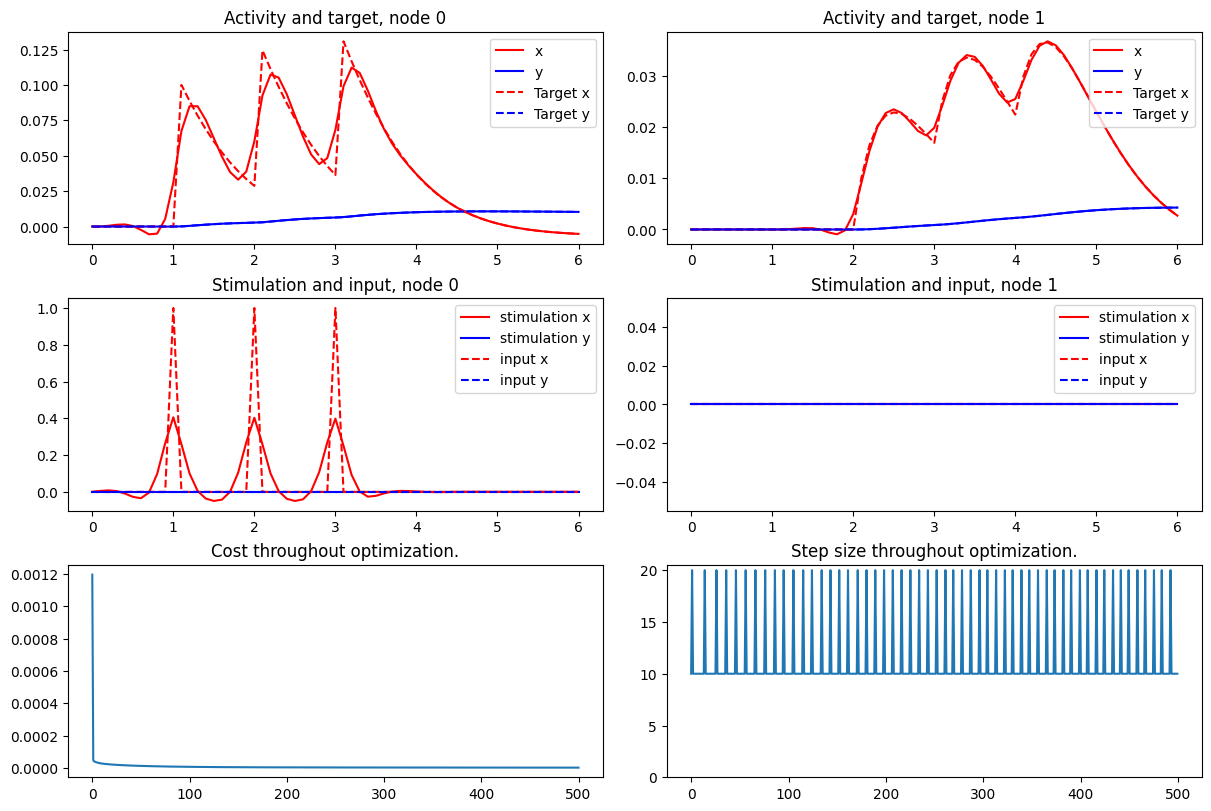

In [11]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
if model.name == "fhn":
    model_controlled = oc_fhn.OcFhn(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
elif model.name == "hopf":
    model_controlled = oc_hopf.OcHopf(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 1.9532206049661995e-06
Cost in iteration 25: 1.8983582753730306e-06
Cost in iteration 50: 1.8467668220809645e-06
Cost in iteration 75: 1.7980710643859726e-06
Cost in iteration 100: 1.7518998980010859e-06
Final cost : 1.7518998980010859e-06


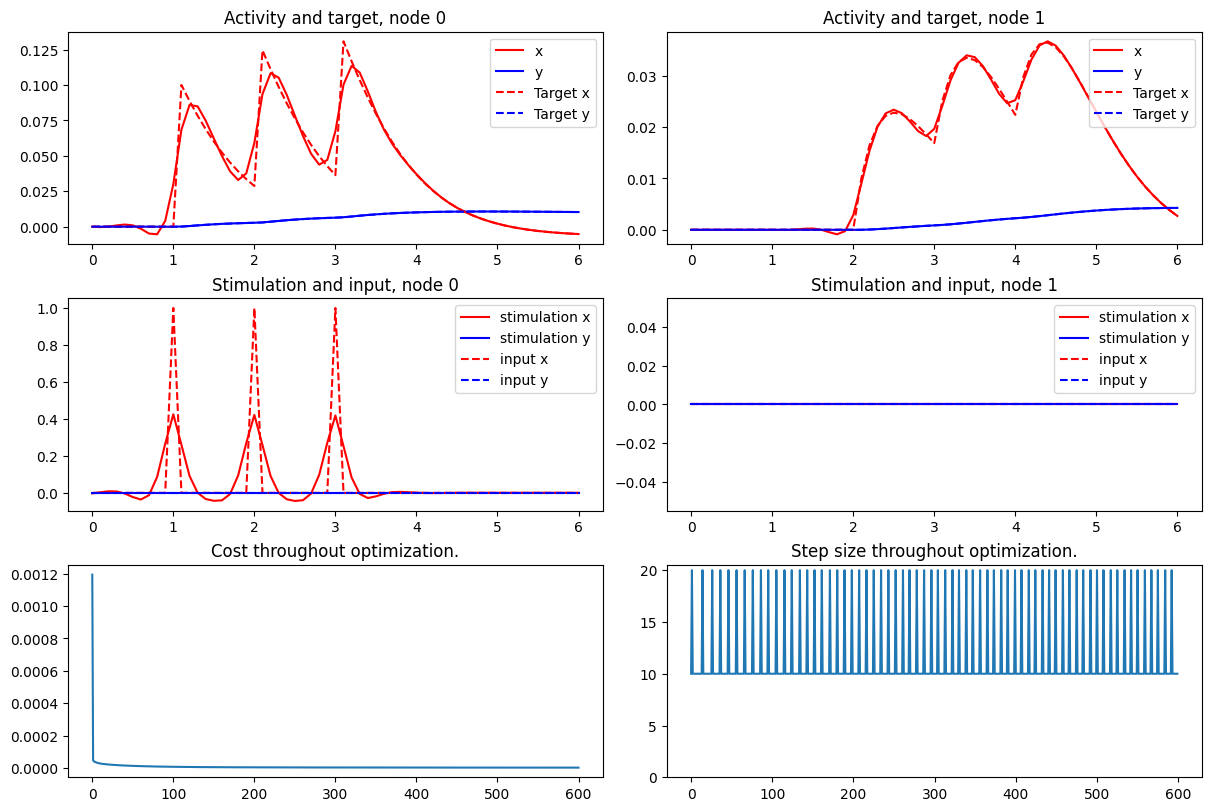

In [12]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 100 iterations
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)